# Train, assess, and use pySCN classifier

In this brief tutorial, we show you how to train a pySCN classifier, assess its performance, and use it to predict the cell type of independent data.

## Data

We will use the training data that was processed in the [prepare training data](how-to_prepare_reference_data) tutorial. And we will use another PBMC data as the query data:

- 20k Human PBMCs, 3' HT v3.1, Chromium X
- Sourced from a healthy female donor
- 23,837 cells
- 35,000 reads per cell
- Filtered data in .h5 format
- [20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5](https://cf.10xgenomics.com/samples/cell-exp/6.1.0/20k_PBMC_3p_HT_nextgem_Chromium_X/20k_PBMC_3p_HT_nextgem_Chromium_X_filtered_feature_bc_matrix.h5)


## Load packages

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy as sp
import numpy as np
import anndata
import pySingleCellNet as pySCN
import igraph as ig
import altair as alt
from joblib import dump, load
import sys

sc.settings.verbosity = 3 
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==2.0.0 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.9.11 pynndescent==0.5.8


## Load data

:::{important}
pySCN assumes that the expression estimates are in their raw, un-transformed state. While a shifted log normalization should not be a detriment to classifier performance, inputing scaled data will reduce performance.
:::

In [2]:
adRef = sc.read_h5ad("../howto_pbmc10k/adPBMC_ref_040523.h5ad")
adQ1 = sc.read_h5ad("../pbmc_query/adPBMC_query_1_20k_HT_040723.h5ad")

## Limit to genes shared in both data sets

In [3]:
pySCN.limit_anndata_to_common_genes([adRef, adQ1])

## Train classifier

First, we will split the reference data into the training set made up of equal numbers of cells per cell type, and a held out data set.

In [4]:
adTrain, adHeldOut = pySCN.splitCommonAnnData(adRef, ncells=50,dLevel="celltype")

FCGR3A monocyte : 
327
NK cell : 
608
CD4 T cell : 
3554
Dendritic : 
154
Megakaryocyte : 
59
CD14 monocyte : 
3128
B cell : 
1450
CD8 T cell : 
1029


Now, we will train the pySCN classifier. 

In [5]:
clf = pySCN.scn_train(adTrain, dLevel = 'celltype', nTopGenes = 200, nTopGenePairs = 200, nRand = 100, nTrees = 1000, stratify=False, propOther=0.1)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
HVG
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Matrix normalized
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
There are  1103  classification genes

B cell
CD14 monocyte
CD4 T cell
CD8 T cell
Dendritic
FCGR3A m

## Classify held out data and assess

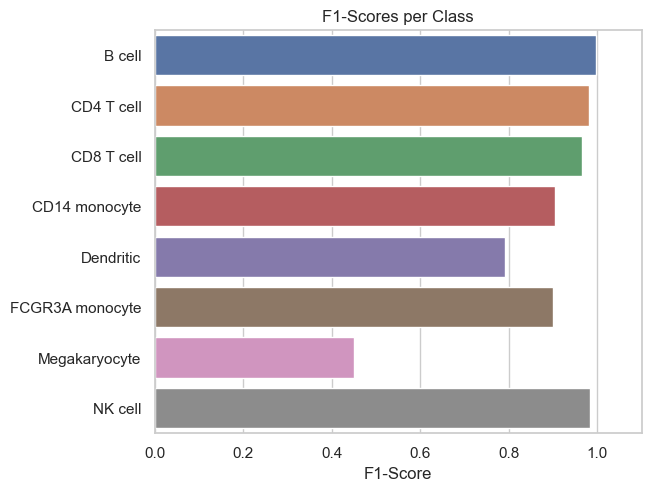

In [6]:
pySCN.scn_classify(adHeldOut, clf, nrand = 0)
pySCN.barplot_classifier_f1(adHeldOut, ground_truth="celltype", class_prediction="SCN_class")

## Classify query data

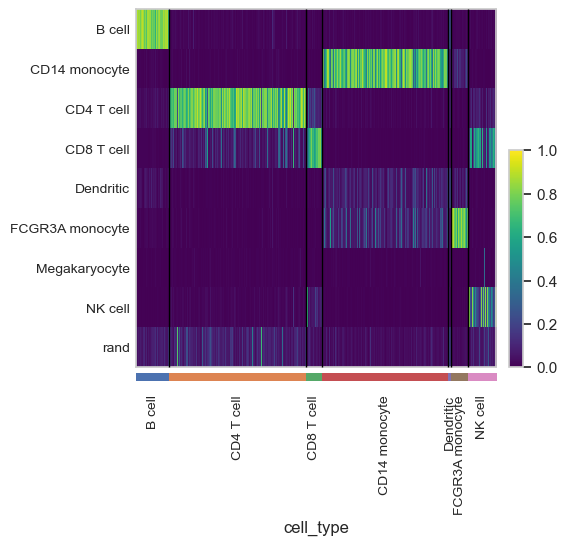

In [8]:
pySCN.scn_classify(adQ1, clf, nrand = 0)

# Note that the "cell_type" obs is derived from manual annotation based on marker expression. 
pySCN.heatmap_scn_scores(adQ1, groupby='cell_type')

We can also arrange the cells based on the cell type in which the received the highest classification score (softmax).

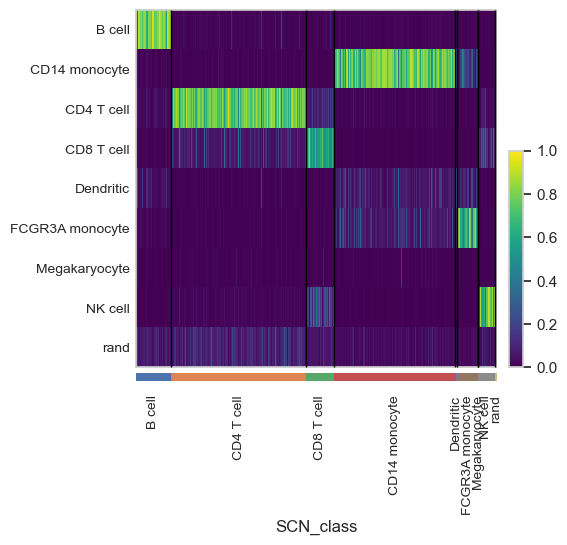

In [9]:
pySCN.heatmap_scn_scores(adQ1, groupby='SCN_class')

We can embed the query data and see how SCN classification and SCN scores are distributed across clusters

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 11
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    fini

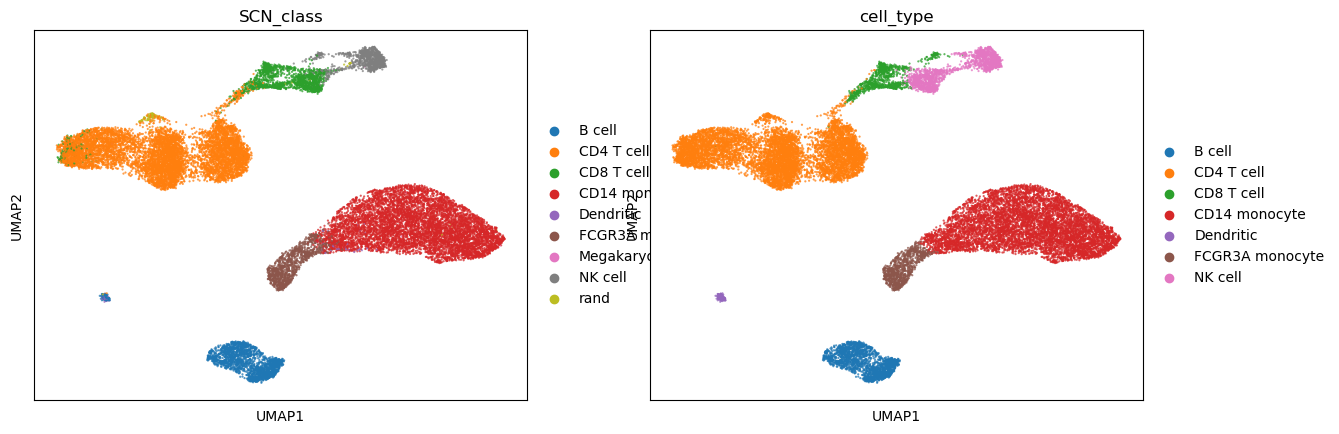

In [10]:
adQ1_norm = pySCN.norm_hvg_scale_pca(adQ1)

npcs = 11
sc.pp.neighbors(adQ1_norm, n_neighbors=25, n_pcs=npcs)
sc.tl.leiden(adQ1_norm,.1)

sc.tl.paga(adQ1_norm)
sc.pl.paga(adQ1_norm, plot=False)
sc.tl.umap(adQ1_norm, 0.25, init_pos='paga')

plt.rcdefaults()
# plt.subplots(layout="constrained")
#plt.rcParams.update({"figure.autolayout": True})
sc.pl.umap(adQ1_norm,color=['SCN_class', 'cell_type'], alpha=.75, s=10)

Examining the SCN_score can help to explain why there are differences in the manual annotation and pySCN classification in the CD8 T cells and NK cell groups.

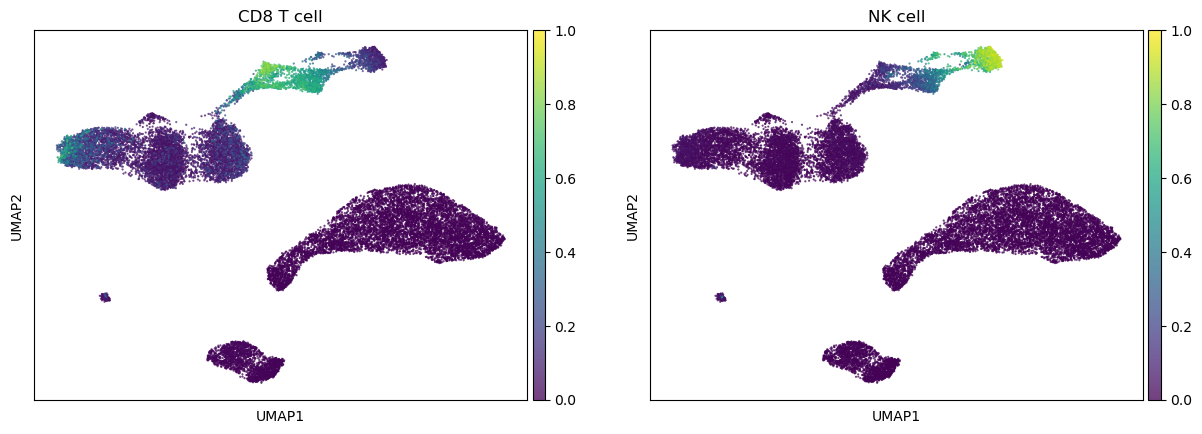

In [11]:
pySCN.umap_scn_scores(adQ1_norm, ["CD8 T cell", "NK cell"])